# Optics Matching & Slow Extraction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xtrack as xt

%config InlineBackend.figure_format = "retina"

### Load Model and Set Initial Strengths

In [2]:
env = xt.Environment.from_json("pimm.json")
ring = env["ring"]

Loading line from dict:   0%|          | 0/148 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
# Assigned 'randomly' to get a computable Twiss
env["kqfa"] = 0.01
env["kqfb"] = 0.01
env["kqd"] = -0.02

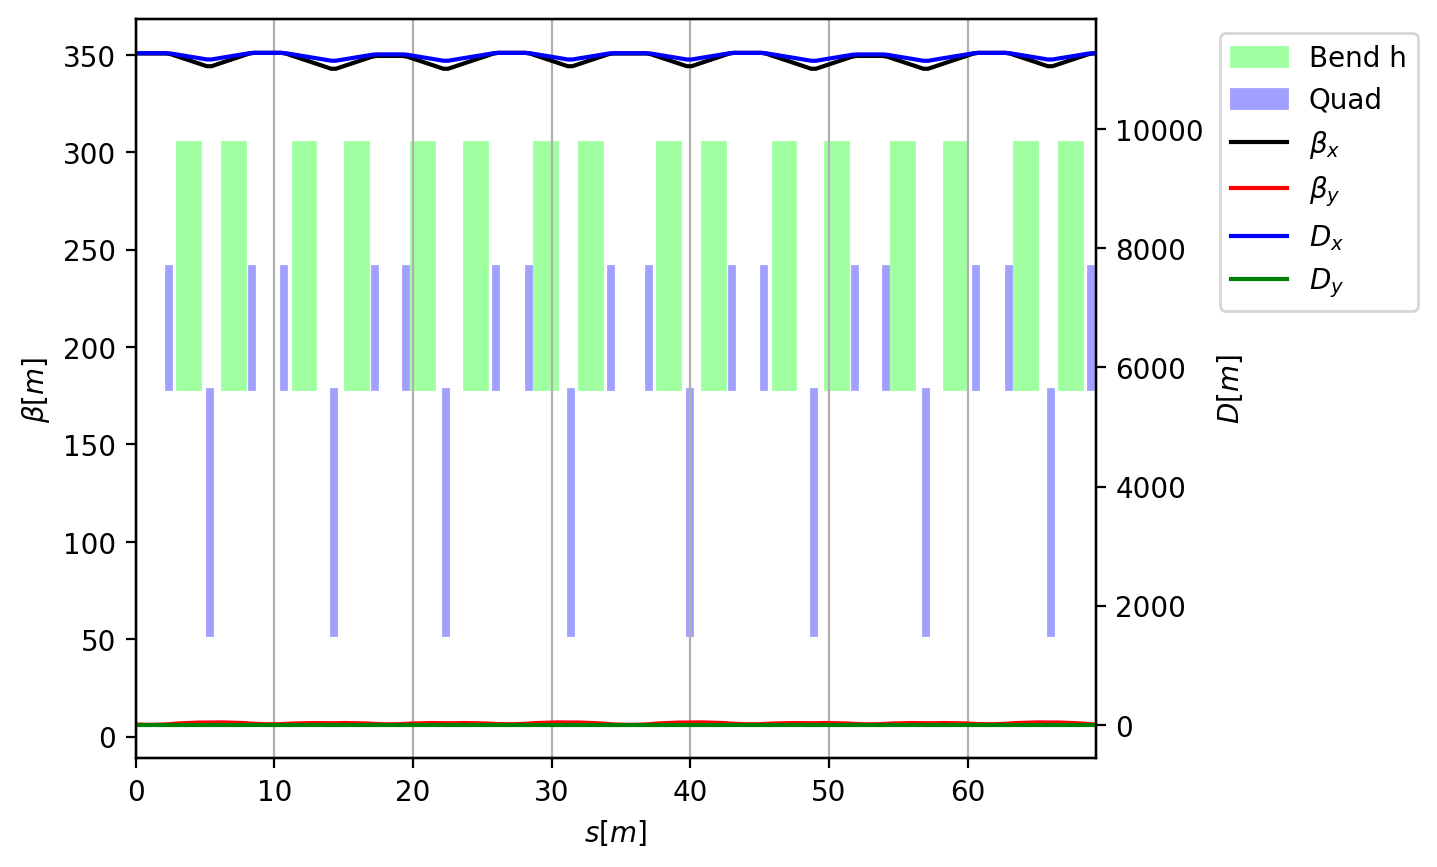

In [4]:
twiss = ring.twiss4d(compute_chromatic_properties=False)
twiss.plot()

### Match the Tunes

In [5]:
opt_tune = ring.match(
    solve=False,  # <- prepare the match but do not run
    vary=[
        xt.Vary("kqfa", limits=(0, 10), step=1e-3),
        xt.Vary("kqfb", limits=(0, 10), step=1e-3),
        xt.Vary("kqd", limits=(-10, 0), step=1e-3),
    ],
    targets=[
        # Horizontal tune close to 3rd order resonance
        xt.TargetSet(qx=1.665, qy=1.72, tol=1e-4),
    ],
    compute_chromatic_properties=False,
    method="4d",
)

In [6]:
opt_tune.target_status()

Target status:               alty = 1.6354e+01              
id state tag tol_met       residue   current_val    target_val description                           
0  ON    qx    False      -1.63364     0.0313645         1.665 'qx', val=1.665, tol=0.0001, weight=10
1  ON    qy    False     -0.075345       1.64466          1.72 'qy', val=1.72, tol=0.0001, weight=10 


In [7]:
opt_tune.run_jacobian(30)

                                             
Optimize - start penalty: 16.35                             
Matching: model call n. 22 penalty = 5.5533e-06              
Optimize - end penalty:  5.55333e-06                            


In [8]:
opt_tune.target_status()

Target status:               nalty = 5.5533e-06              
id state tag tol_met       residue   current_val    target_val description                           
0  ON    qx     True  -4.86092e-07         1.665         1.665 'qx', val=1.665, tol=0.0001, weight=10
1  ON    qy     True   2.68532e-07          1.72          1.72 'qy', val=1.72, tol=0.0001, weight=10 


In [9]:
opt_tune.vary_status()

Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqfa           0      0.440823          10          0.01         0.001             1
1  ON        OK  kqfb           0      0.448292          10          0.01         0.001             1
2  ON        OK  kqd          -10     -0.588114           0         -0.02         0.001             1


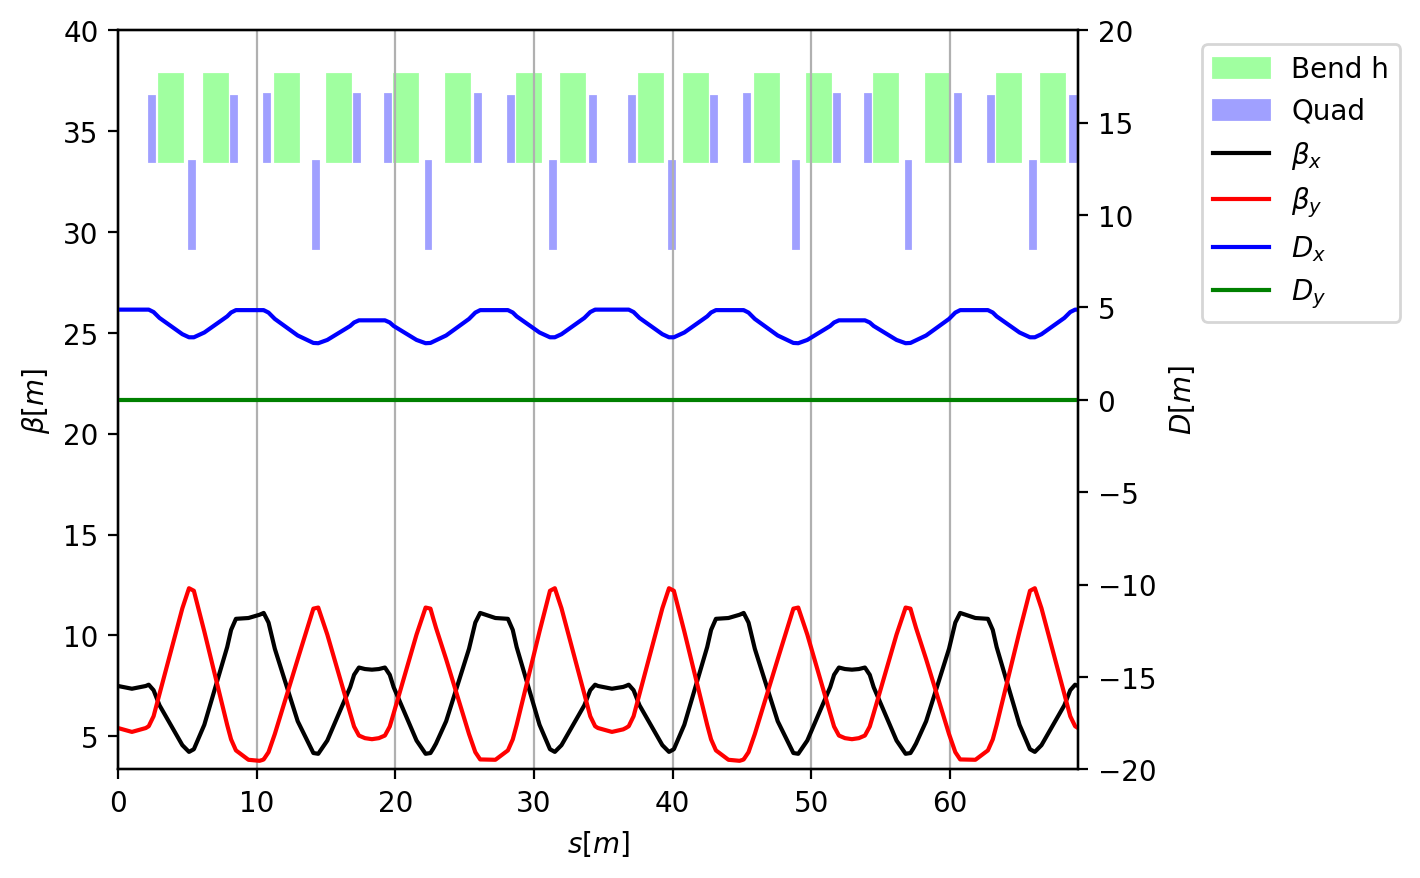

In [10]:
# Inspect the optics
twiss = ring.twiss4d()
plot = twiss.plot()
plot.ylim(left_hi=40, right_lo=-20, right_hi=20, lattice_hi=1.5, lattice_lo=-7)

### Add Dispersion Constraint at Center of the Long Straight Sections

In [11]:
opt_disp = opt_tune.clone(  # clone to keep previous constraints!
    add_targets=[
        xt.TargetSet(dx=0, at="mid.lss.0"),
        xt.TargetSet(dx=0, at="mid.lss.1"),
    ]
)

In [12]:
opt_disp.target_status()

Target status:               alty = 6.9037e+01              
id state tag          tol_met       residue   current_val    target_val description                                 
0  ON    qx              True  -4.86092e-07         1.665         1.665 'qx', val=1.665, tol=0.0001, weight=10      
1  ON    qy              True   2.68532e-07          1.72          1.72 'qy', val=1.72, tol=0.0001, weight=10       
2  ON    mid.lss.0_dx   False       4.88163       4.88163             0 ('dx', 'mid.lss.0'), val=0, tol=1e-09, w ...
3  ON    mid.lss.1_dx   False       4.88163       4.88163             0 ('dx', 'mid.lss.1'), val=0, tol=1e-09, w ...


In [13]:
opt_disp.run_simplex(100)  # Nelder-Mead optimisation algorithm

                                             
Optimize - start penalty: 69.04                             
Matching: model call n. 182 penalty = 4.5799e-03              
Optimize - end penalty:  0.00457993                            


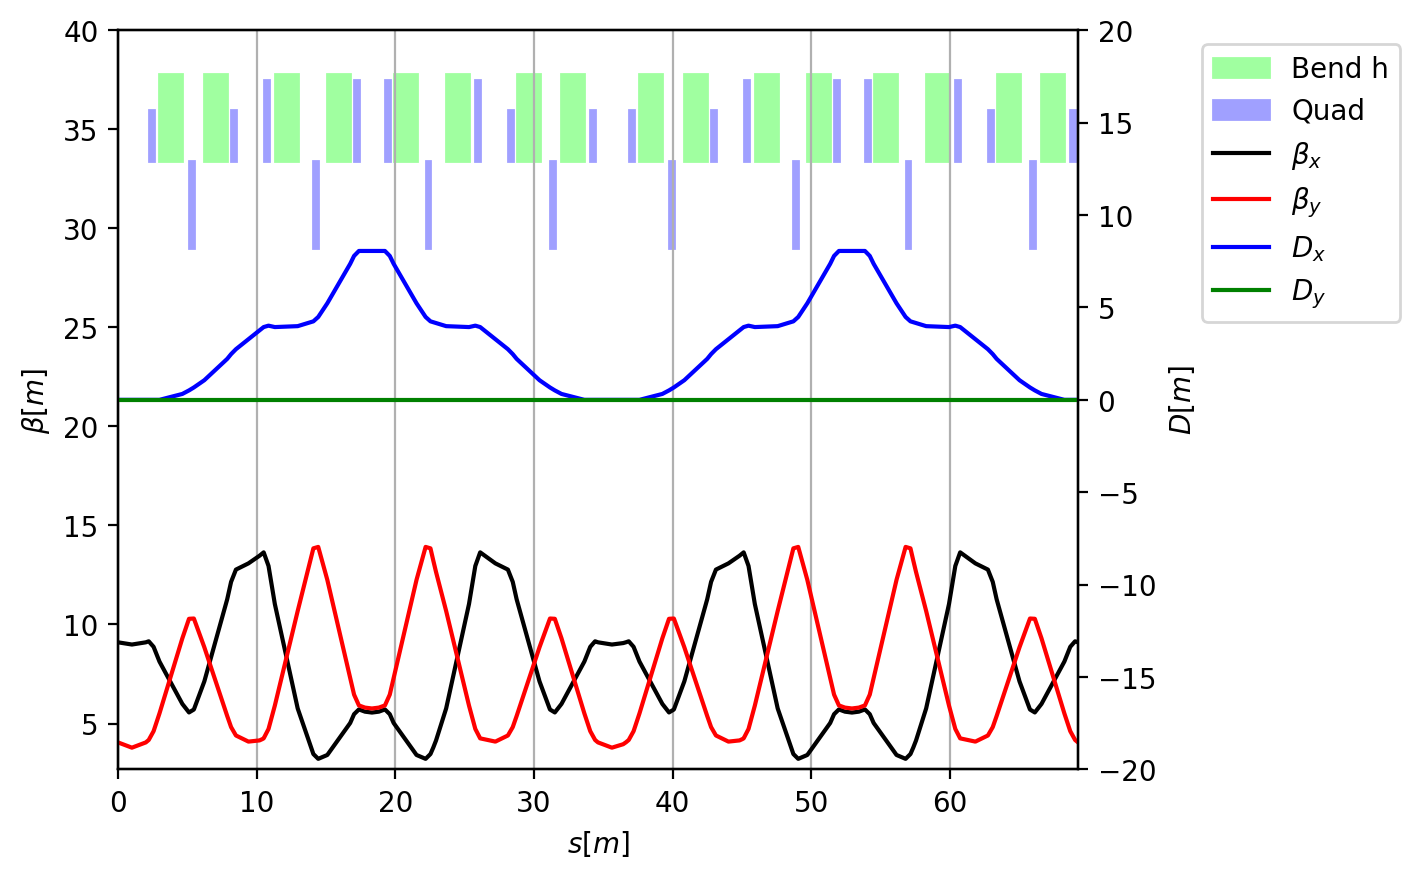

In [14]:
# Inspect the optics
twiss = ring.twiss4d()
plot = twiss.plot()
plot.ylim(left_hi=40, right_lo=-20, right_hi=20, lattice_hi=1.5, lattice_lo=-7)

## Correct Chromaticity

In [15]:
opt_chrom = ring.match(
    solve=True,
    method="4d",
    vary=xt.VaryList(["ksf", "ksd"], step=1e-3),
    targets=xt.TargetSet(dqx=-0.01, dqy=-0.01, tol=1e-3),
)

                                             
Optimize - start penalty: 1.211                             
Matching: model call n. 5 penalty = 7.9294e-05              
Optimize - end penalty:  7.92942e-05                            


In [16]:
opt_chrom.run_ls_dogbox(30)  # Least squares, dobgox algorithm

Matching: model call n. 40 penalty = 1.9317e-08              

In [17]:
opt_chrom.target_status()

Target status:               nalty = 1.9317e-08              
id state tag tol_met       residue   current_val    target_val description                          
0  ON    dqx    True  -1.25913e-08         -0.01         -0.01 'dqx', val=-0.01, tol=0.001, weight=1
1  ON    dqy    True   1.46491e-08   -0.00999999         -0.01 'dqy', val=-0.01, tol=0.001, weight=1


## Observe Phase Space Deformation when Exciting the Resonance

In [18]:
# Generate 20 particles on the x axis
x_gen = np.linspace(0, 0.5e-2, 20)
parts = ring.build_particles(x=x_gen, px=0, y=0, py=0, zeta=0, delta=0)

In [19]:
# Set extraction sextupole
env["kse"] = 6

# Track 1000 turns
ring.track(parts.copy(), num_turns=1000, turn_by_turn_monitor=True)
record = ring.record_last_track

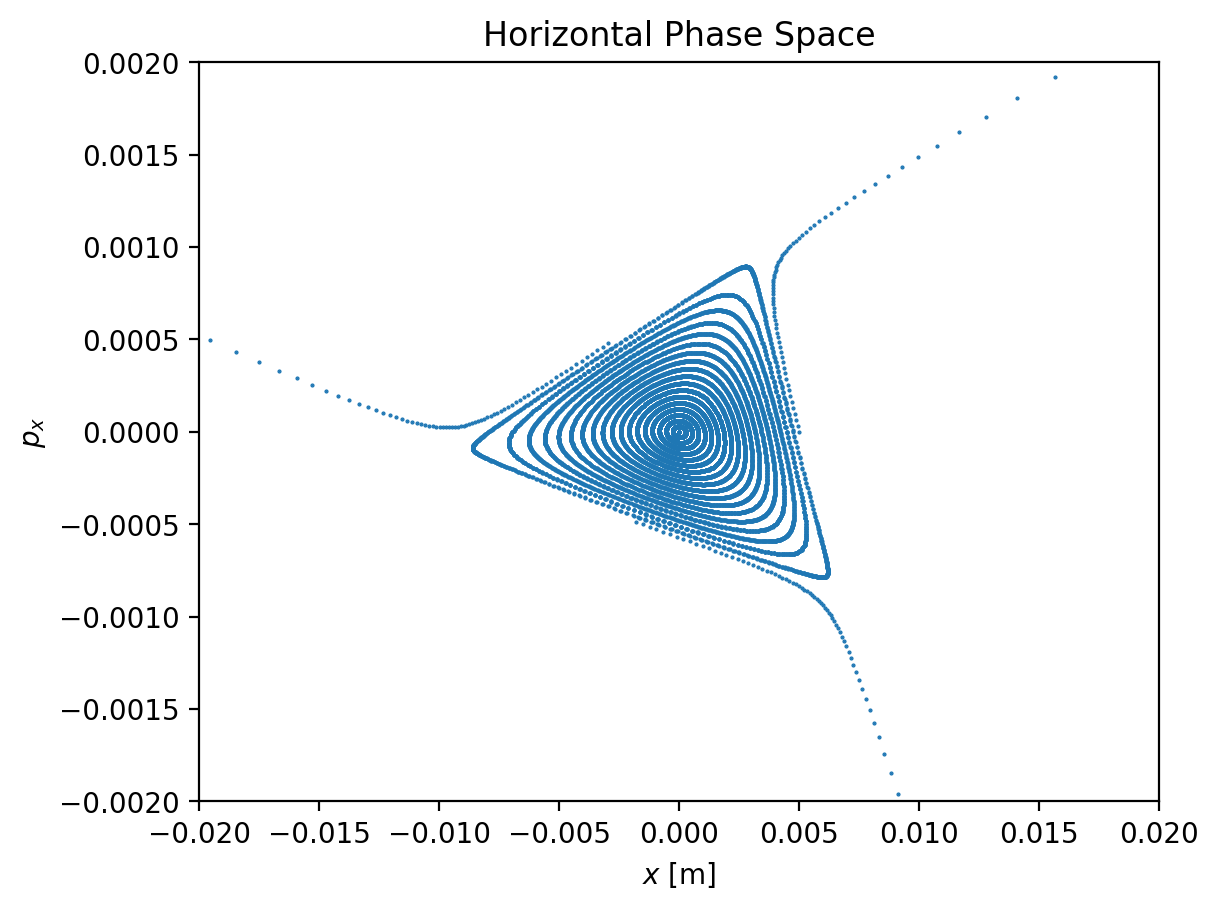

In [20]:
# Plot turn-by-turn data
plt.figure()
plt.plot(record.x.T, record.px.T, ".", markersize=1, color="C0")
plt.xlim(-2e-2, 2e-2)
plt.ylim(-2e-3, 2e-3)
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$p_x$")
plt.title("Horizontal Phase Space")
plt.subplots_adjust(left=0.15)
plt.show()

### Exports Settings

In [21]:
# Extract the strengths from optimisers
quad_strengths: dict[str, float] = opt_disp.get_knob_values()
sext_strengths: dict[str, float] = opt_chrom.get_knob_values()

In [22]:
# Merge dictionaries and save to file
strengths = quad_strengths | sext_strengths
xt.json.dump(strengths, "pimm_strengths.json")

---